The goal of this assignment is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
# import time
# import matplotlib.pyplot as plt

### Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


### Read the data into a string

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    for name in f.namelist():    
        print('name: %s' % name)
        print('type: %s' % type(name))
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size: %d' % len(words))

name: text8
type: <type 'str'>
Data size: 17005207


### Build the dictionary and replace rare words with UNK token.

In [4]:
## exclude words in stoplist
stoplist = set('for a b c d e f g h i j k l m n o p q r s t u v w x y z \
    an th the'.split())

In [5]:
words = [i for i in words if i not in stoplist]
print ('Data size', len(words))

Data size 15117753


In [6]:
vocabulary_size = 50000  # orig 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print ('Most common words (+UNK): ', count[:15])
print ('Sample data (indexes of words): ',  data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK):  [['UNK', 418121], ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('to', 316376), ('zero', 264975), ('nine', 250430), ('two', 192644), ('is', 183153), ('as', 131815), ('eight', 125285), ('five', 115789), ('three', 114775), ('was', 112807)]
Sample data (indexes of words):  [5209, 3054, 10, 177, 1, 3107, 41, 54, 140, 115]


### Function to generate a training batch for the skip-gram model.

In [7]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'term', 'term', 'of', 'of']
    labels: ['as', 'anarchism', 'term', 'originated', 'as', 'of', 'abuse', 'term']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'term', 'term', 'term', 'term']
    labels: ['anarchism', 'originated', 'term', 'of', 'abuse', 'as', 'originated', 'of']


### Look into the data

In [8]:
print (len(data), data[-10:])
print (len(count), count[-10:])

15117753 [13987, 4, 3, 7, 18, 13, 3, 7, 18, 12]
50000 [('myelogenous', 9), ('gyre', 9), ('beckenbauer', 9), ('ulbricht', 9), ('quartermaster', 9), ('guericke', 9), ('creams', 9), ('yetzer', 9), ('vasoconstriction', 9), ('lockhart', 9)]


In [9]:
# begining of corpus, with indexes
for i in (data)[:10]:
    print (reverse_dictionary[i], i)

anarchism 5209
originated 3054
as 10
term 177
of 1
abuse 3107
first 41
used 54
against 140
early 115


In [10]:
# end of corpus, with indexes
for i in (data)[-20:]:
    print (reverse_dictionary[i], i)

masada 28111
was 14
identified 1729
in 4
one 3
eight 11
four 17
two 8
and 2
extensively 3937
excavated 13987
in 4
one 3
nine 7
six 18
three 13
one 3
nine 7
six 18
five 12


In [11]:
for i in dictionary.keys()[-5:]:
    print (i, dictionary[i])

rotting 26417
pods 23251
emery 40147
northerly 23607
expands 14467


In [12]:
for i in reverse_dictionary.items()[:11]:
    print (i)

(0, 'UNK')
(1, 'of')
(2, 'and')
(3, 'one')
(4, 'in')
(5, 'to')
(6, 'zero')
(7, 'nine')
(8, 'two')
(9, 'is')
(10, 'as')


### Train a skip-gram model.

In [13]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size], \
                        stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  print (embed.get_shape().as_list())
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed, \
                        labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings/norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

[128, 128]


### Run the skip-gram model

In [14]:
num_steps = 100001

with tf.Session(graph=graph) as session:
#   tf.initialize_all_variables().run()
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.673464
Nearest to state: smear, headless, traveler, carmel, pool, creeping, remaining, imagination,
Nearest to under: eugenio, translator, condense, frosts, trilemma, mod, corman, benz,
Nearest to united: malvaceae, religiosity, indoctrination, honoria, channing, austin, predication, hohmann,
Nearest to are: shortstop, archaeology, aggregated, subverting, vitruvius, clones, dm, troubling,
Nearest to more: microprogram, dei, zerby, radium, stwa, oliveira, behaviorism, childs,
Nearest to be: inherits, fujimori, endeavored, chelmsford, theropods, mouse, ic, reservoir,
Nearest to no: trafalgar, notebooks, coma, tripolitania, lafur, base, protea, binyamin,
Nearest to most: attended, uprooted, surrounding, soy, alienate, unfolding, contorted, halas,
Nearest to is: invoking, circ, capricorn, viscous, rsted, graduates, milking, fluctuates,
Nearest to they: curie, mock, hallowed, stooges, anthroposophy, gap, wuxia, preview,
Nearest to when: prophesies, appr

### Look at embeddings

In [15]:
print(final_embeddings[0])

[-0.05724738 -0.09509414 -0.00074997 -0.14421104  0.11122573  0.14422999
  0.06570241 -0.00230125 -0.0451342  -0.05845227  0.04255385 -0.01995708
 -0.07788798 -0.02291304 -0.02347129  0.10343954 -0.08028952 -0.01410642
 -0.14538878 -0.15549281 -0.05685893 -0.10522503  0.09272003  0.17018285
 -0.12554894  0.01213969 -0.08752619 -0.16788083 -0.03676346  0.12113556
 -0.05931851  0.01195594 -0.05258345  0.04696191 -0.12578489 -0.07003939
  0.0654157   0.05832422 -0.08763839 -0.0441643  -0.07130753  0.12217659
  0.08563519  0.15072833 -0.063279   -0.0452517  -0.10531534 -0.11007304
  0.18558852  0.0602225   0.02852983  0.02881346 -0.08326002 -0.18801528
 -0.01614091 -0.1413925  -0.00991739 -0.01886465 -0.0662287   0.11451947
 -0.11706598  0.03168516 -0.16283983 -0.01946892 -0.01878433  0.17475516
  0.11412277 -0.00839288  0.07266712  0.13176198  0.14697891  0.01169144
 -0.03665942  0.05124175 -0.09109259 -0.01678124  0.01963085 -0.01046401
  0.07340245  0.03208242  0.06964683  0.09385307 -0

All the values are abstract, there is practical meaning of the them. Moreover, the final embeddings are normalized as you can see here:

In [16]:
print(np.sum(np.square(final_embeddings[0])))

1.0


In [17]:
# source: https://discussions.udacity.com/t/assignment-5-error-in-the-main-code-valueerror-array-must-not-contain-infs-or-nans/178187/9
## if error; the problem is from numpy. Fixing it as follows:
### sudo conda remove numpy --force -y
### sudo pip uninstall numpy -y
### conda install numpy

num_points = 400
## t-Distributed Stochastic Neighbor Embedding (t-SNE) 
## is a technique for dimensionality reduction for the visualization of high-dimensional datasets. 
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

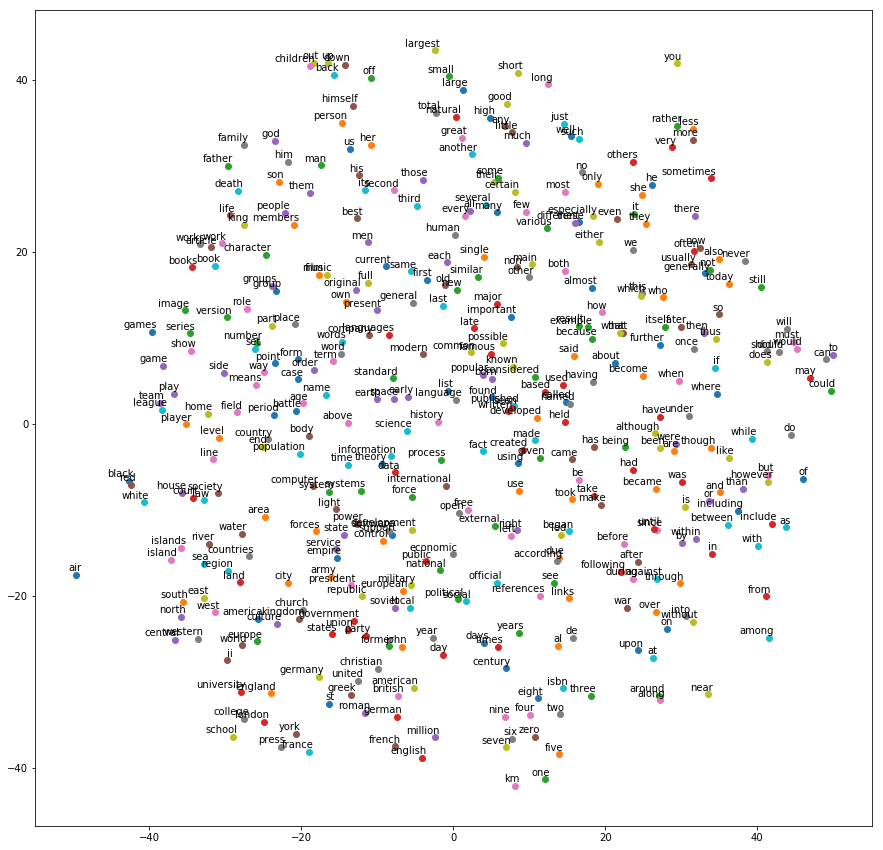

In [18]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

### Problem
An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.


[The skip-gram model tutorial.](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

### Training a CBOW model

Continuous Bag-of-Words Model (CBOW) predicts the current word based on the context. 

We have obtained the best performance on the task introduced in the next section by building a log-linear classifier with four future and four history words at the input, where the training criterion is to correctly classify the current (middle) word. 

CBOW uses continuous distributed representation of the context. Note that the weight matrix between the input and the projection layer is shared for all word positions in the same way as in the NNLM.

CBOW:
```
inputs(embeddings)      projection      output

w(t-2) ---\
w(t-1) -----\____________| sum |__________ w(t)
w(t+1) -----/
w(t+2) ---/
```

Training complexity: `Q = N*D + D*log2(V)`

In [76]:
data_index = 0

def generate_batch(batch_size, bag_window):
  global data_index
  span = 2 * bag_window + 1 # [ bag_window target bag_window ]
  batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)  
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size):
    # just for testing
    buffer_list = list(buffer)
    labels[i, 0] = buffer_list.pop(bag_window)
    batch[i] = buffer_list
    # iterate to the next buffer
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:16]])

for bag_window in [1, 2]:
  data_index = 0
  batch, labels = generate_batch(batch_size=4, bag_window=bag_window)
  print('\nwith bag_window = %d:' % (bag_window))  
  print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])  
  print('    labels:', [reverse_dictionary[li] for li in labels.reshape(4)])

data: ['anarchism', 'originated', 'as', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'diggers', 'of']

with bag_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'term'], ['as', 'of'], ['term', 'abuse']]
    labels: ['originated', 'as', 'term', 'of']

with bag_window = 2:
    batch: [['anarchism', 'originated', 'term', 'of'], ['originated', 'as', 'of', 'abuse'], ['as', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used']]
    labels: ['as', 'term', 'of', 'abuse']


### Build the CBOW graph

In [77]:
# Note: In the loss function, exchanged: reduced_embed and train_labels.

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
# skip_window = 1 # How many words to consider left and right.
###num_skips = 2 # How many times to reuse an input to generate a label.
bag_window = 2 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

    # Model.
    # Look up embeddings for inputs.
    embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
    
    # reduced_embed 
    reduced_embed = tf.div(tf.reduce_sum(embeds, 1), bag_window*2)
    # contruct sum
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the softmax loss, using a sample of the negative labels each time. 
    ## exchanged: reduced_embed and train_labels.
    ### https://stackoverflow.com/a/43787255/2881205
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, train_labels, tf.reduce_sum(embeds, 1),
                                                     num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [78]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, bag_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.524580
Nearest to its: microscope, councils, crespigny, daniell, cetacea, carlo, diametrically, theorizing,
Nearest to are: meades, arguing, hourglass, surrealism, suggestibility, oint, ansgar, crushing,
Nearest to war: paley, add, uttered, indexing, grievances, tatar, vuoksi, phi,
Nearest to than: tapestry, ega, intrauterine, haggard, spills, survey, recognition, pharsalus,
Nearest to over: awhile, vig, beth, anion, fullest, clade, morphemes, lica,
Nearest to it: drpg, baskerville, span, katana, enz, reef, trill, catalyst,
Nearest to more: nun, ddt, passos, peerless, treviso, humorists, pollution, decoction,
Nearest to on: umayyad, cherokee, replicators, lessens, definitions, hatches, emulation, baptists,
Nearest to such: clover, sds, distribute, patriarch, bars, ebooks, coder, legate,
Nearest to three: culprits, mild, slays, disrupts, hesychastic, dov, inpatient, boldly,
Nearest to united: dalnet, glaciers, hynek, interconnected, heft, syntactic,

In [79]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])


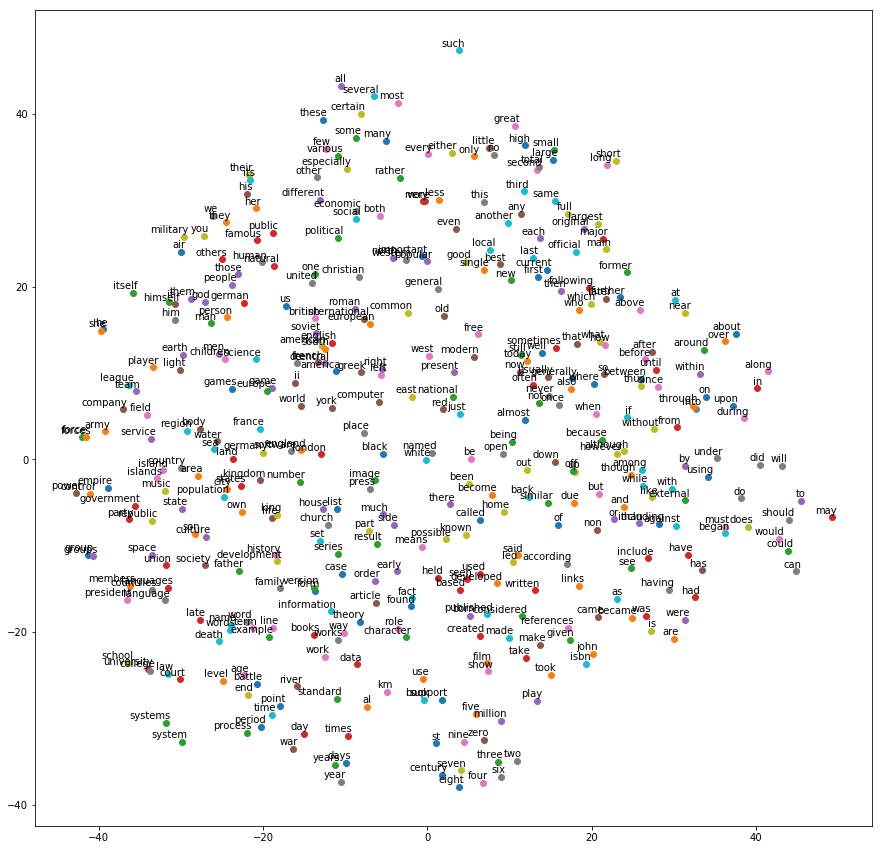

In [80]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

#### Conlusion: CBOW model is more accurate than skip-gram model, as it predicts the target based on the context, while SKIP-GRAM model predicts surrounding words given the current word.